In [1]:
import numpy as np
import datetime
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

In [2]:
glucose_path = "../data/blood-glucose.csv"
motion_path = "../data/motion.tsv"
TIMESPAN_H = 48
INTERVAL_M = 15
WALKING_COLUMN = 2

In [3]:
df_glucose = pd.read_csv(glucose_path, header=None)
df_motion = pd.read_csv(motion_path, sep='\t', header=None)

df_glucose[0] = df_glucose[0].apply(lambda elem: pd.to_datetime(elem))
df_motion[0] = df_motion[0].apply(lambda elem: pd.to_datetime(elem))

In [4]:
df_glucose.head()

,0,1
0,2017-05-23 00:00:00,NaN
1,2017-05-23 00:15:00,NaN
2,2017-05-23 00:30:00,NaN
3,2017-05-23 00:45:00,NaN
4,2017-05-23 01:00:00,NaN


In [5]:
start_date_motion = df_motion[0].min().floor(str(INTERVAL_M)+'T')
start_date_glucose = df_glucose[0].min().floor(str(INTERVAL_M)+'T')

end_date_motion = df_motion[0].max()
end_date_glucose = df_glucose[0].max()

if start_date_motion > start_date_glucose:
    start_date = start_date_motion
else:
    start_date = start_date_glucose
if end_date_motion > end_date_glucose:
    end_date = end_date_glucose
else:
    end_date = end_date_motion
    
all_intervals = pd.date_range(start_date, end_date, freq=str(INTERVAL_M)+'T')
nr_of_elems = int(TIMESPAN_H*60/float(INTERVAL_M))

In [6]:
def get_motion_hist():
    motion_array = np.zeros(shape=(len(all_intervals)-nr_of_elems,))
    i = 0
    for timestamp in all_intervals[:500]:
        
        t_index = all_intervals.get_loc(timestamp)
        if t_index+1 < nr_of_elems:
            continue
  
        if i%100==0:
            print('measurement', i, '/', len(all_intervals)-nr_of_elems)

        end_interval = timestamp
        start_interval = all_intervals[t_index-nr_of_elems]
        mask = (df_motion[0] > start_interval) & (df_motion[0] <= end_interval)

        # get rows within interval
        selected_rows = df_motion.loc[mask]
        
        time_walking = 0
        walking = False
        start_walking = None
        end_walking = None

        for index, row in selected_rows.iterrows():
            if row[WALKING_COLUMN] == 1:
                start_walking = row[0]
                walking = True
            elif row[WALKING_COLUMN] == 0 and walking:
                end_walking = row[0]
                duration = (end_walking-start_walking).total_seconds()
                time_walking += duration
                walking = False
        if walking:
            duration = (end_interval-start_walking).total_seconds()
            time_walking += duration

        motion_array[i] = time_walking
        
        i += 1
    motion_array = motion_array[:i]
    print('stopped here at i =', i, ', because of resource limits')
    return motion_array

In [10]:
def get_glucose_devs():
    gluc_array = np.zeros(shape=(len(all_intervals)-nr_of_elems,))
    i = 0
    for timestamp in all_intervals[:500]:

        t_index = all_intervals.get_loc(timestamp)
        if t_index+1 < nr_of_elems:
            continue
            
        if i%100==0:
            print('row', i, '/', len(all_intervals)-nr_of_elems)

        end_interval = timestamp
        start_interval = all_intervals[t_index-nr_of_elems]
        mask = (df_glucose[0] > start_interval) & (df_glucose[0] <= end_interval)

        # get rows within interval
        selected_rows = df_glucose.loc[mask]
        
        # Fill in missing values by mean
        # selected_rows[1].fillna(selected_rows[1].mean())
        
        glucose_std_dev = selected_rows[1].std()
        gluc_array[i] = glucose_std_dev
        
        i += 1
    gluc_array = gluc_array[:i]
    print('stopped here at i =', i, ', because of resource limits')
    return gluc_array

In [11]:
gluc_array = get_glucose_devs()

row 0 / 841
row 100 / 841
row 200 / 841
row 300 / 841
stopped here at i = 309 , because of resource limits


In [9]:
motion_array = get_motion_hist()

measurement 0 / 841
measurement 100 / 841
measurement 200 / 841
measurement 300 / 841
stopped here at i = 309 , because of resource limits


[[1.         0.53675989]
 [0.53675989 1.        ]]


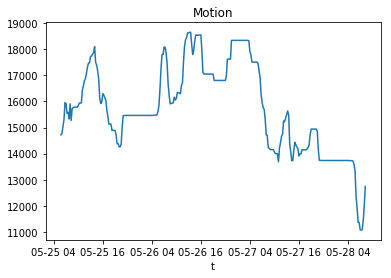

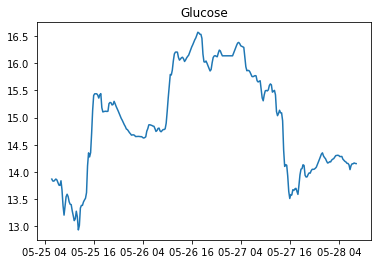

In [12]:
x_motion = motion_array[10:]
x_gluc = gluc_array[10:]

print(np.corrcoef(x_motion, x_gluc))

plt.figure()
plt.plot(all_intervals[nr_of_elems:nr_of_elems+len(x_motion)], x_motion)
plt.title("Motion")
plt.xlabel("t")
plt.figure()
plt.plot(all_intervals[nr_of_elems:nr_of_elems+len(x_gluc)], x_gluc)
plt.title("Glucose")

# I should shuffle actually
train_motion = np.reshape(x_motion[:200], newshape=(len(x_motion[:200]),1))
train_gluc = np.reshape(x_gluc[:200], newshape=(len(x_gluc[:200]),1))

test_motion = np.reshape(x_motion[200:], newshape=(len(x_motion[200:]),1))
test_gluc = np.reshape(x_gluc[200:], newshape=(len(x_gluc[200:]),1))

The two correlate negatively between timestep 10-100 (-0.60). This is to be expected because low activity level results in a high glucose level.

However, a moderate positivel correlation is found over the whole sequence (0.53). This is not expected.

In [13]:
model = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5), random_state=1)
model.fit(train_motion, train_gluc)
pred_gluc = model.predict(test_motion)
print('mean squared error: ', mean_squared_error(test_gluc, pred_gluc))

mean squared error:  0.9519497398521822


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
